# BME280 Sensor Analysis Session
Welcome to the BME280 sensor data analysis session using python

In [2]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
import cartopy
import datetime
from datetime import datetime

# I. Prepare the data

In [3]:
# Merge multiple .txt files (GPS data) into one file

import glob
import os

# remote gps.txt if exists
if os.path.exists("gps.txt"):
    # Remove the file
    os.remove("gps.txt")

read_files = glob.glob("*.txt")
header = "type,date time,latitude,longitude,accuracy(m),altitude(m),geoid_height(m),speed(m/s),bearing(deg),sat_used,sat_inview,name,desc".encode('utf-8')

with open("gps.txt", "wb") as outfile:
    # Write a header
    outfile.write(header + b"\n")
    for f in read_files:
        with open(f, "rb") as infile:
            # Skip the first line
            next(infile)
            # Write the rest of the file to the result file
            for line in infile:
                outfile.write(line)

Read in appropriate files and datasets

In [4]:
# Read in files
file = open("Anna.CSV")
gps_file = open("gps.txt")

# Open files as datasets
dataset = pd.read_csv(file)
gps_data = pd.read_csv(gps_file)

Prepare the data - remove unnecessary subheaders and columns

In [5]:
dataset = dataset[dataset["Date"] != "Date"]
gps_data = gps_data.drop(columns=['type','geoid_height(m)','speed(m/s)','bearing(deg)','sat_used','sat_inview','name','desc'])

We need to merge the datasets due to not recording GPS on the sensors, we will also have to make some data conversions to make plotting and analysis easier:

Need to convert datetime columns to datetime objects:
Converts into the format: yyyy-mm-dd hh:mm:ss

In [6]:
dataset["Datetime"] = pd.to_datetime(dataset['Date'] + " " + dataset["Time"], format='%Y-%m-%d %H:%M:%S')
gps_data["date time"] = pd.to_datetime(gps_data['date time'], format='%Y-%m-%d %H:%M:%S')

dataset['Time'] = dataset['Datetime'].dt.time
dataset['Date'] = dataset['Datetime'].dt.date

We now need to sort the data to ensure it is chronological order:

In [7]:
dataset_sorted = dataset.sort_values('Datetime')
gps_data_sorted = gps_data.sort_values('date time')

Merge through by matching nearest datetime values. This tags the latitude and longitude columns onto your data array

In [9]:
data = pd.merge_asof(dataset_sorted, gps_data_sorted, left_on='Datetime', right_on='date time', direction='nearest', tolerance=pd.Timedelta(minutes=5))

Ignore the data where the difference between sensor and GPS datetimes is too large (more than 5min)

In [10]:
data = data[data["date time"].notna()]

Have a look at the data

In [11]:
data

,Date,Time,Temperature(C),Pressure(hPa),Altitude(m),Humidity(%),Datetime,date time,latitude,longitude,accuracy(m),altitude(m)
26,2024-03-12,15:53:00,24.45,1022.28,-74.93,58.12,2024-03-12 15:53:00,2024-03-12 15:57:44.327,28.030542,-16.561455,8.0,80.312
27,2024-03-12,15:54:00,23.58,1022.25,-74.62,61.75,2024-03-12 15:54:00,2024-03-12 15:57:44.327,28.030542,-16.561455,8.0,80.312
28,2024-03-12,15:55:00,23.03,1022.3,-75.06,66.36,2024-03-12 15:55:00,2024-03-12 15:57:44.327,28.030542,-16.561455,8.0,80.312
29,2024-03-12,15:56:00,23.56,1022.2,-74.23,62.09,2024-03-12 15:56:00,2024-03-12 15:57:44.327,28.030542,-16.561455,8.0,80.312
30,2024-03-12,15:57:00,23.04,1022.41,-75.95,66.44,2024-03-12 15:57:00,2024-03-12 15:57:44.327,28.030542,-16.561455,8.0,80.312
...,...,...,...,...,...,...,...,...,...,...,...,...
1279,2024-03-17,16:52:00,21.27,800.67,1942.59,40.08,2024-03-17 16:52:00,2024-03-17 16:51:07.000,28.766048,-17.899760,2.0,2116.200
1280,2024-03-17,16:53:00,21.47,798.64,1963.05,39.24,2024-03-17 16:53:00,2024-03-17 16:51:07.000,28.766048,-17.899760,2.0,2116.200
1281,2024-03-17,16:54:00,21.66,794.61,2004.02,37.69,2024-03-17 16:54:00,2024-03-17 16:51:07.000,28.766048,-17.899760,2.0,2116.200
1282,2024-03-17,16:55:00,21.81,791.17,2038.72,36.56,2024-03-17 16:55:00,2024-03-17 16:51:07.000,28.766048,-17.899760,2.0,2116.200


For daily cycles, we need to convert the time into plottable numeric data, and convert other columns into numeric data:

In [12]:
data['time_numeric'] = data['Time'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

numeric_cols = data.columns.difference(['Date', 'Time', 'Datetime', 'date time'])  # Exclude datetime column
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric)

### Daily mean data
Doing the same as we did for time but for date allows us to compute daily means etc.

In [24]:
# We can now calculate the mean temperature, etc. of our data by grouping by the day it was measured on:
day_temp = data.groupby('Date')['Temperature(C)'].mean()
# This returns a series with the index being the day and the values are the temperatures
day_humid = data.groupby('Date')['Humidity(%)'].mean()
day_pressure = data.groupby('Date')['Pressure(hPa)'].mean()

# II. Figure Plotting

### 1. Simple time series - Temperature change over the whole trip

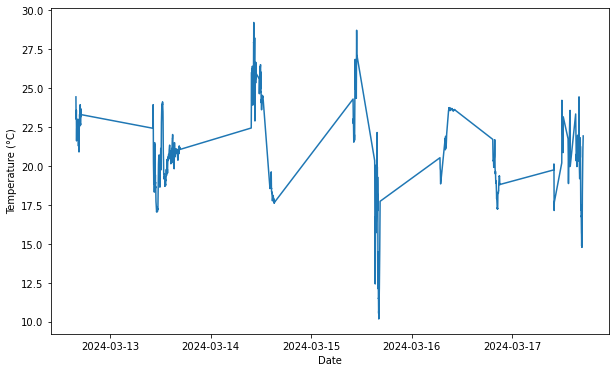

In [23]:
# This figure plots a timeseries of temperature
# Start figure
plt.figure(figsize=(10,6))
# Tell it what to plot
plt.plot(data['Datetime'], data['Temperature(C)'])
# You can plot a specific date only:
#plot_date = pd.Timestamp('2024-03-15')
#plt.plot(data[data['Date'] == plot_date]['Datetime'], data[data['Date'] == plot_date]['Temperature(C)'])

# Label axes
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()

**Task**: Check the temperature timeseries for the second dataset

### 2. Daily patterns over the whole trip

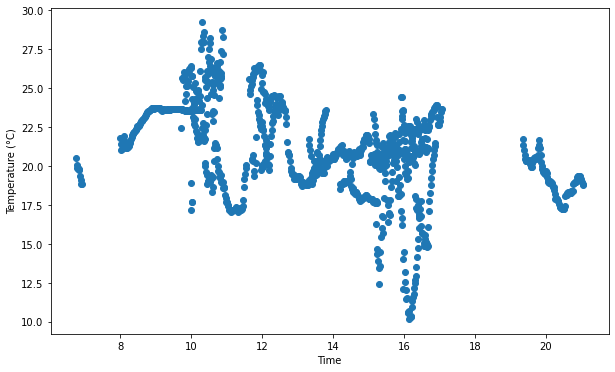

In [17]:
# This figure plots a timeseries of temperature but with the day component removed
# Start figure
plt.figure(figsize=(10,6))
# We can change the type of plot if necessary: (I've changed this one to a scatter)
plt.scatter(data['time_numeric'], data['Temperature(C)'])
# Label axes
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()

**Task**: Discuss whether this is a useful information :)

### 3. Plot daily average for the entire trip

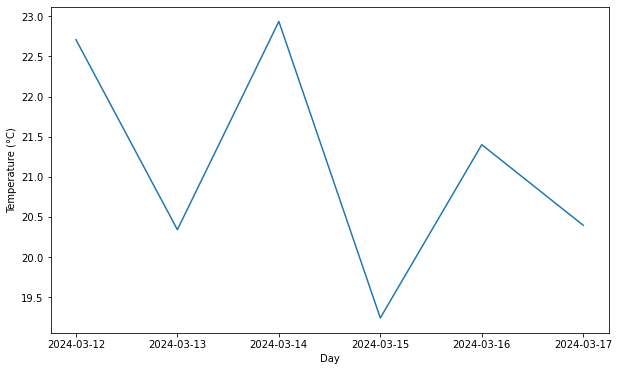

In [25]:
# This figure plots a timeseries of temperature but as a daily mean
# Start figure
plt.figure(figsize=(10,6))
# tell it what to plot
plt.plot(day_temp.index, day_temp)
# label axes
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()

**Task**: Produce plots for pressure and humidity

### 4. Compare data between sensors (Anna vs Harry)

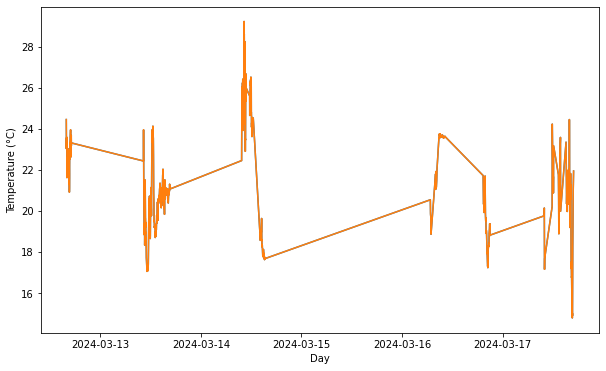

In [33]:
# This figure plots a timeseries of temperature but as a daily mean
# Start figure
plt.figure(figsize=(10,6))
# tell it what to plot
exclude_dates = [pd.Timestamp('2024-03-13'), pd.Timestamp('2024-03-15')]
# Anna data
plt.plot(
    data[~data['Date'].isin(exclude_dates)]['Datetime'],
    data[~data['Date'].isin(exclude_dates)]['Temperature(C)'])
# Harry data
plt.plot(
    data[~data['Date'].isin(exclude_dates)]['Datetime'],
    data[~data['Date'].isin(exclude_dates)]['Temperature(C)'])
# label axes
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()


**Task**: Investigate the mismatch at a finer temporal resolution

### 5. Maps

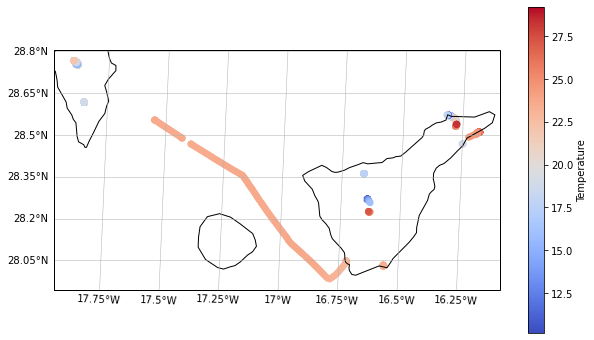

In [26]:
# This figure maps temperature data on a scatterplot for our fieldwork
# Start figure
plt.figure(figsize=(10, 6))
# Setup axes with map projection
ax = plt.axes(projection = cartopy.crs.Robinson())
# Add coastlines
ax.coastlines(resolution = '10m')
# Add scattered data
sc = ax.scatter(data['longitude'], data['latitude'], c= data['Temperature(C)'], cmap = 'coolwarm', marker = 'o', transform = cartopy.crs.PlateCarree())
# Setup colorbar
cbar = plt.colorbar(sc, ax = ax, label = 'Temperature')
# Figure outline
ax.spines['geo'].set_linewidth(1)
# Setup gridlines
gl = ax.gridlines(linewidth=0.5, draw_labels=True, crs=cartopy.crs.PlateCarree())
# Remove right side and top of figure labels
gl.right_labels = False
gl.top_labels = False
# to save the figure, delete the hashtag and re-run
# plt.savefig('map.png', dpi = 300)
plt.show()

**Task**: Create maps for humidity and pressure.

**Task**: Zoom in to a specific activity (choose an activity/day like in Plot 1)